## Deep learning/Reinforcement learning in Time series data: Stock price verion

Our goal is to predict close price using our model from previous input <br>
Episode one: https://www.kaggle.com/peraktong/transformer-ts   <br>
Please let me know if you have any question.   <br>
Thanks to this useful link : https://www.tensorflow.org/tutorials/text/transformer   <br>
Thanks to this useful link: https://www.kaggle.com/itoeiji/deep-reinforcement-learning-on-stock-data  <br>
Thanks to this useful link: https://towardsdatascience.com/aifortrading-2edd6fac689d <br>
Thanks to this useful link: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial <br>
Thanks to this useful link: https://rubikscode.net/2019/07/08/deep-q-learning-with-python-and-tensorflow-2-0/ <br>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import tensorflow as tf
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
color_array = list(mcolors.CSS4_COLORS.keys())
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
names_list = []
for dirname, _, filenames in os.walk('Data/Stocks/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        
        names_list.append(filename)
names_list = np.array(names_list)


# TPU session :)
# detect and init the TPU
if False:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    

In [2]:
root_path = 'Data/Stocks/'
#root_path = "/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/"

df = pd.read_csv(root_path + "googl.us.txt")

In [3]:
df.head()


,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


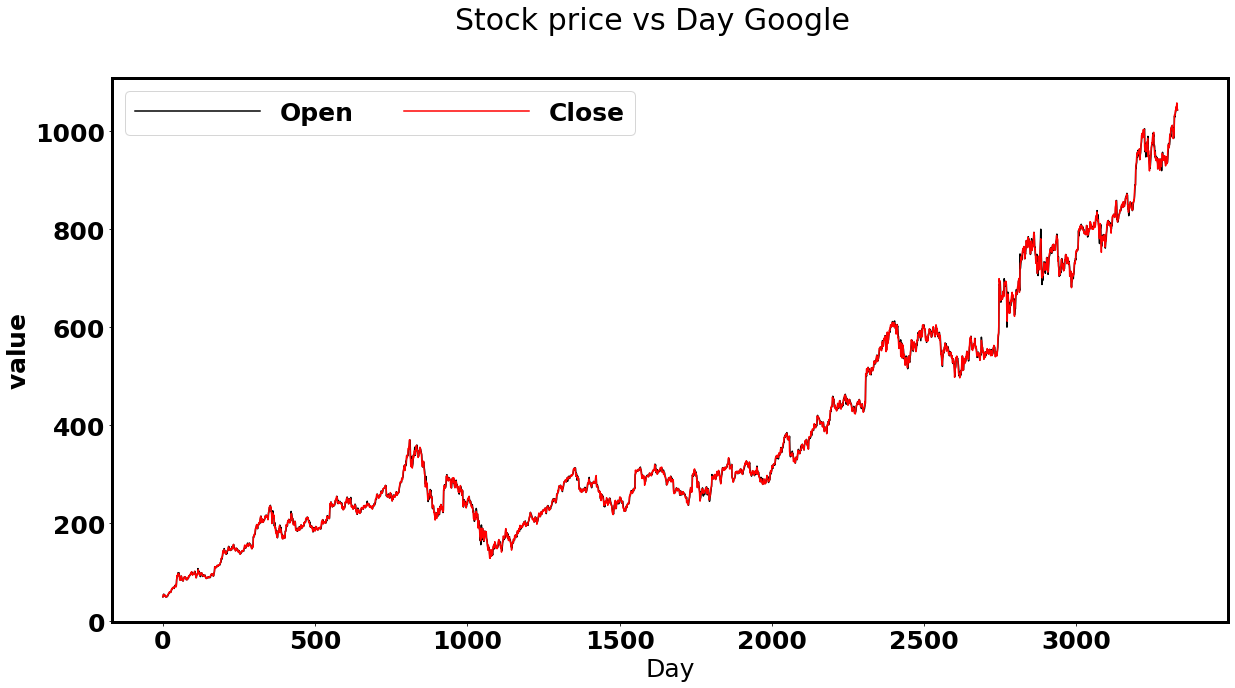

In [4]:
import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(1,1,1)
plt.plot(df["Open"],"k",label="Open")
plt.plot(df["Close"],"r",label="Close")


plt.xlabel("Day")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Day Google")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend(fontsize=25,handlelength=5,ncol=3)
plt.show()

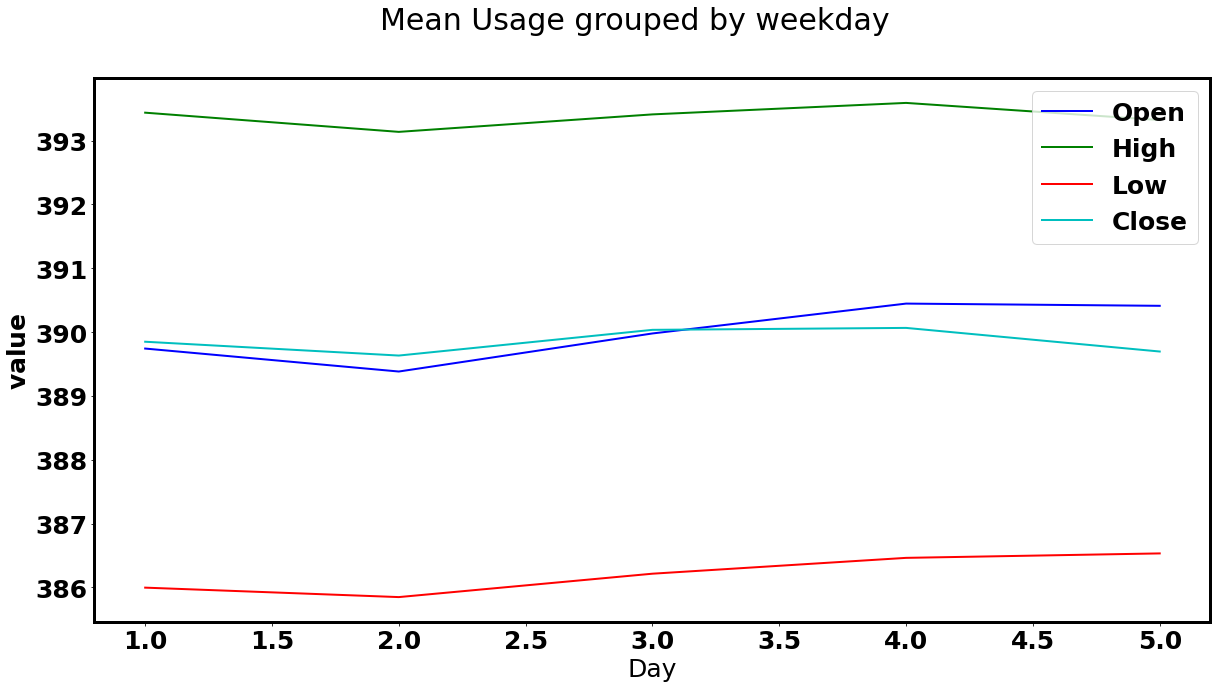

In [5]:
# Let's check whether there is a peroid in week/month?
import datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['weekday'] = df['Date'].dt.weekday
df['monthday'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

color_array = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.subplot(1,1,1)


names_array = list(df.keys()[1:5])
for i in range(len(names_array)):
    #print("Doing %d"%i)
    plt.plot(df.groupby('weekday').mean().index+1,df.groupby('weekday').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("Day")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Mean Usage grouped by weekday")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

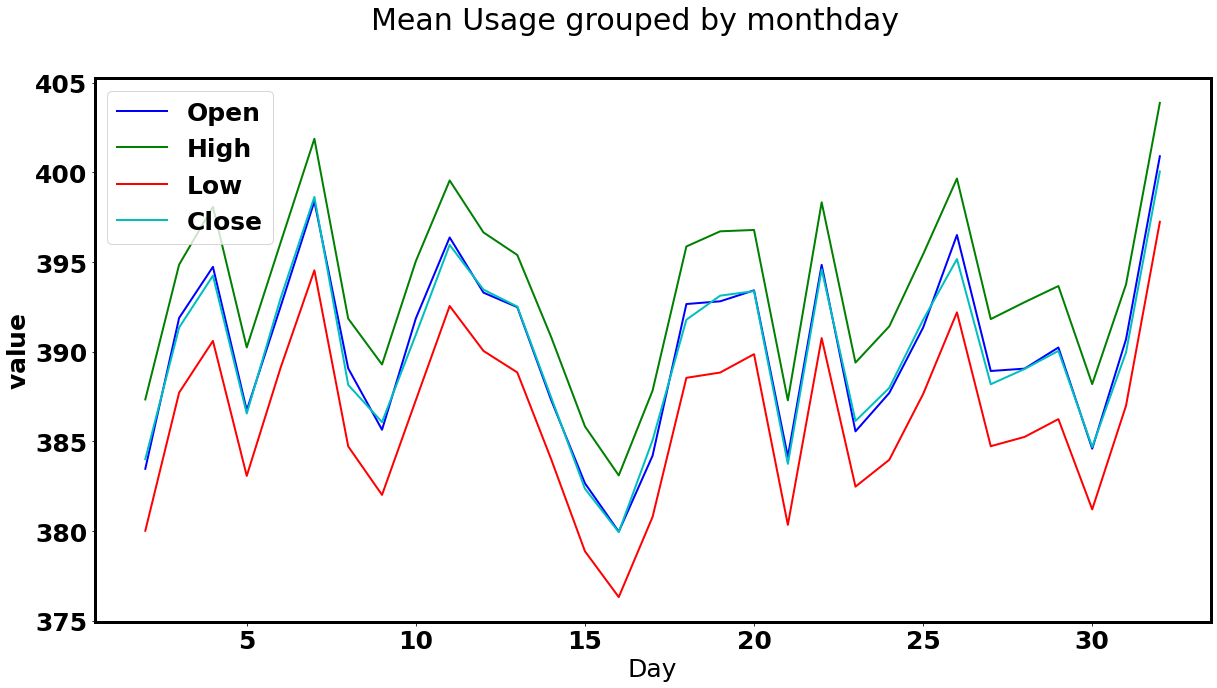

In [6]:
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

color_array = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.subplot(1,1,1)


names_array = list(df.keys()[1:5])
for i in range(len(names_array)):
    #print("Doing %d"%i)
    plt.plot(df.groupby('monthday').mean().index+1,df.groupby('monthday').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("Day")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Mean Usage grouped by monthday")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

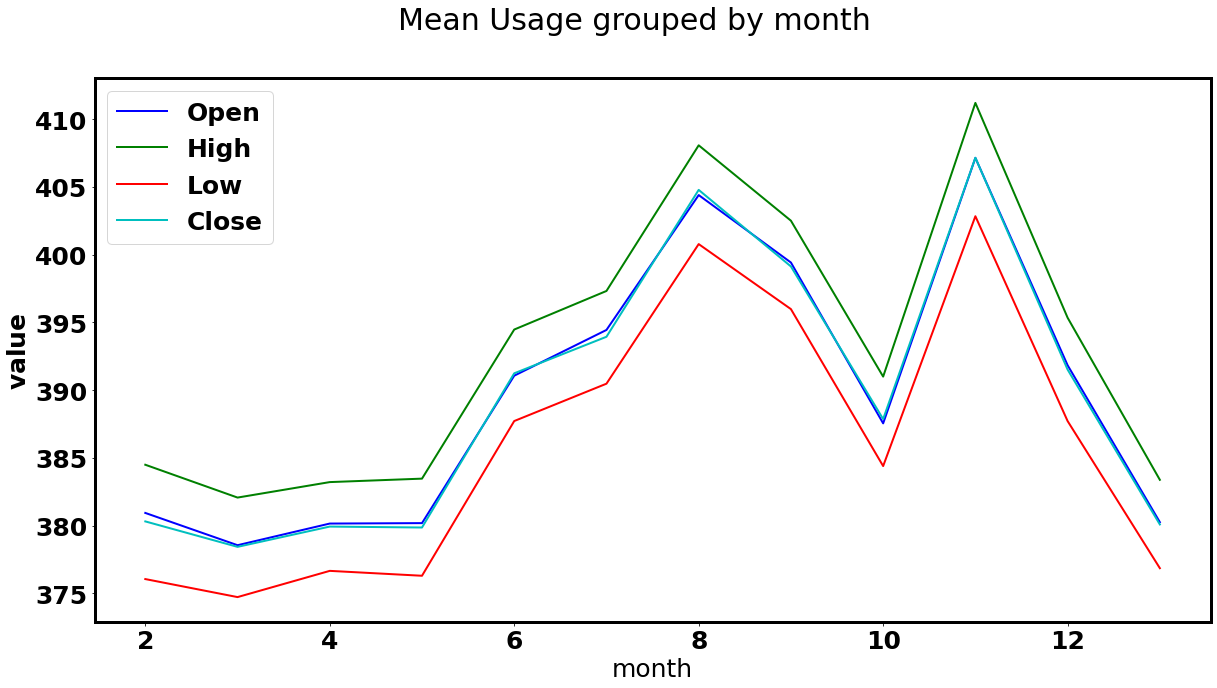

In [7]:
# By month?


from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

color_array = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.subplot(1,1,1)


names_array = list(df.keys()[1:5])
for i in range(len(names_array)):
    #print("Doing %d"%i)
    plt.plot(df.groupby('month').mean().index+1,df.groupby('month').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("month")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Mean Usage grouped by month")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

# baseline model: GRU+Dense layer structure:

In [12]:
from sklearn import preprocessing
from keras.models import Model
from sklearn.preprocessing import LabelEncoder 
import tensorflow as tf
from keras.layers import Input,Masking,Dense,GRU
from sklearn.model_selection import train_test_split 
from keras.layers import Dropout


In [13]:
# some hyper parameters
# Here we use 30 day data to predict future stock price. May need to modify later
delta_t = 30
n_cell = 50
dropout_rate= 0.1
n_epoch=30
batch=256

In [14]:
checkpoint_path = "model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,len(names_array)),dtype=float)
y = df_scaled["Close"][delta_t:]

  
for i in range(len(y)):
    if i%800==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = df_scaled[i:i+delta_t][names_array].values

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

Prepare data 0.00 percent
Prepare data 24.22 percent
Prepare data 48.44 percent
Prepare data 72.66 percent
Prepare data 96.88 percent


In [15]:
def generate_model(MAX_TIMESTEPS,MAX_NB_VARIABLES):
    ip = Input(shape=(MAX_TIMESTEPS,MAX_NB_VARIABLES))
    # split into x and y two channels

    x = Masking()(ip)
    x = GRU(n_cell)(x)

    out = Dense(1)(x)
    #out = Dropout(dropout_rate)(x)
    #loc, scale = tf.keras.layers.GaussianNoise(stddev=0.01)(out)
    
    # now we only output loc
    #out=loc

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

model = generate_model(delta_t,X.shape[2])
model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 4)]           0         
_________________________________________________________________
masking (Masking)            (None, 30, 4)             0         
_________________________________________________________________
gru (GRU)                    (None, 50)                8400      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=batch, validation_data=(X_test, y_test),callbacks=[callback], verbose=2, shuffle=False)

Epoch 1/30

Epoch 00001: saving model to model/cp.ckpt
10/10 - 2s - loss: 0.6025 - val_loss: 0.2666
Epoch 2/30

Epoch 00002: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.1754 - val_loss: 0.1587
Epoch 3/30

Epoch 00003: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.1070 - val_loss: 0.0618
Epoch 4/30

Epoch 00004: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.0652 - val_loss: 0.0540
Epoch 5/30

Epoch 00005: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.0576 - val_loss: 0.0427
Epoch 6/30

Epoch 00006: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.0432 - val_loss: 0.0430
Epoch 7/30

Epoch 00007: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.0424 - val_loss: 0.0387
Epoch 8/30

Epoch 00008: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.0363 - val_loss: 0.0361
Epoch 9/30

Epoch 00009: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.0341 - val_loss: 0.0319
Epoch 10/30

Epoch 00010: saving model to model/cp.ckpt
10/10 - 0s - loss: 0.0315 - val_loss: 0.0302

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)

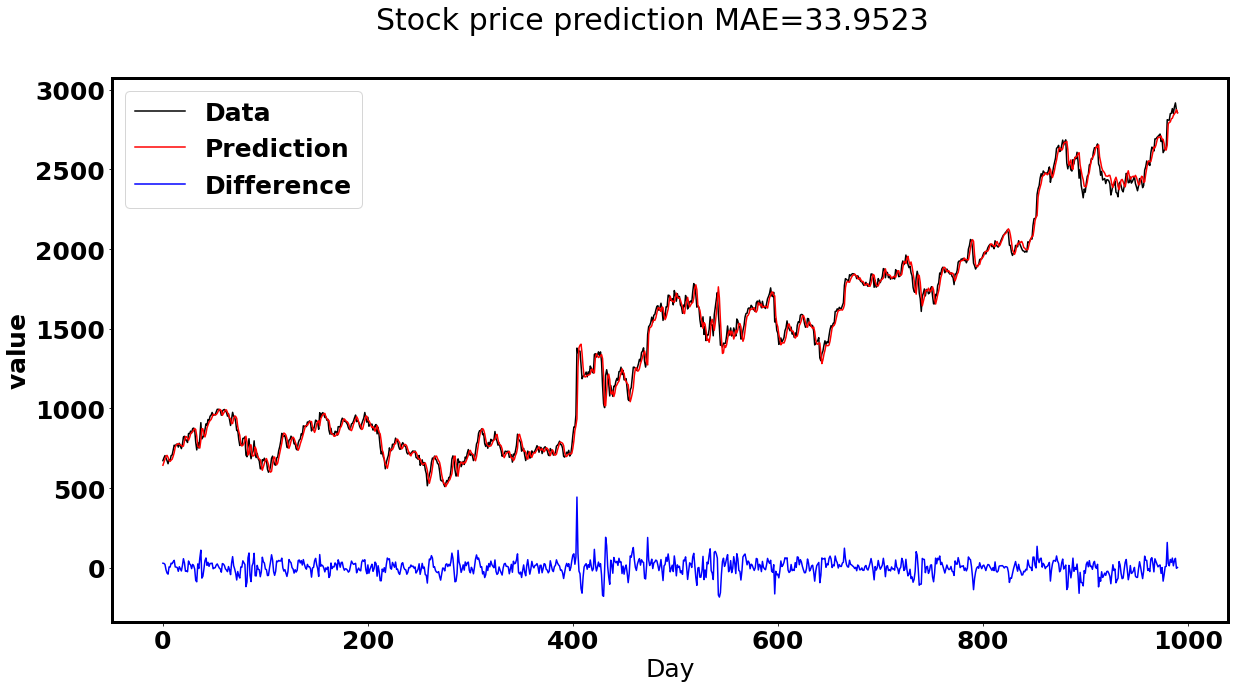

In [19]:
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

color_array = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.subplot(1,1,1)

min_val = np.nanmin(df["Close"])
max_val = np.nanmax(df["Close"])



date_array = np.arange(0,len(y_test),1)

y1 = min_val+(max_val-min_val)*y_test
y2 = min_val+(max_val-min_val)*y_pre[:,0]
plt.plot(date_array,y1,"k",label = "Data")
plt.plot(date_array,y2,"r",label = "Prediction")
plt.plot(date_array,y1-y2,"b",label = "Difference")
plt.xlabel("Day")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price prediction MAE=%.4f"%np.nanmean(abs(y1-y2)))

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

## The prediction seems to have a "Latency" inside.
## Let's try the Q-net <br>
In Q-learning we learn the value of taking an action from a given state. Q-value is the expected return after taking the action. We will use Rainbow which is a combination of seven Q learning algorithms.

In [8]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done

In [9]:

df = pd.read_csv(root_path + "googl.us.txt")
df['Date'] = pd.to_datetime(df['Date'])
data = df.set_index('Date')

env = Environment1(df)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    #print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:

delta_split = int(df.shape[0]*0.7)

train = df[:delta_split]
test = df[delta_split:]
print("Training date length",len(train),"testing date length", len(test))

Training date length 2333 testing date length 1000


In [12]:
import chainer
import chainer.functions as F
import chainer.links as L
import copy
import time



def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    # GPU Option
    #Q.to_gpu()
    
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)
    
    # Hyper-parameters
    epoch_num = 80
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5


    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards


In [13]:
# Let's do it!
Q, total_losses, total_rewards = train_dqn(Environment1(train))

5	0.0999999999999992	11660	-285.2	51965.05232162122	117.4800820350647
10	0.0999999999999992	23320	-80.8	1027.4448142735287	115.84095358848572
15	0.0999999999999992	34980	-74.4	3630.1065551162233	119.9200279712677
20	0.0999999999999992	46640	-7.6	185.28804305889645	116.4130527973175
25	0.0999999999999992	58300	1.0	94.8101543105673	125.79910039901733
30	0.0999999999999992	69960	6.0	120.34398262030444	120.16545987129211
35	0.0999999999999992	81620	12.0	119.88713874976384	122.6151556968689
40	0.0999999999999992	93280	31.0	67.79507062511402	144.38074707984924
45	0.0999999999999992	104940	5.8	44.29382843388188	156.40249943733215
50	0.0999999999999992	116600	-15.6	201.66404752623004	173.08997201919556
55	0.0999999999999992	128260	-12.8	28.744812113972795	161.46913695335388
60	0.0999999999999992	139920	-10.8	27.08253281260819	146.28055715560913
65	0.0999999999999992	151580	-13.0	29.144518221883402	172.47554302215576
70	0.0999999999999992	163240	-12.0	30.49970243915491	149.4571647644043
75	0.09

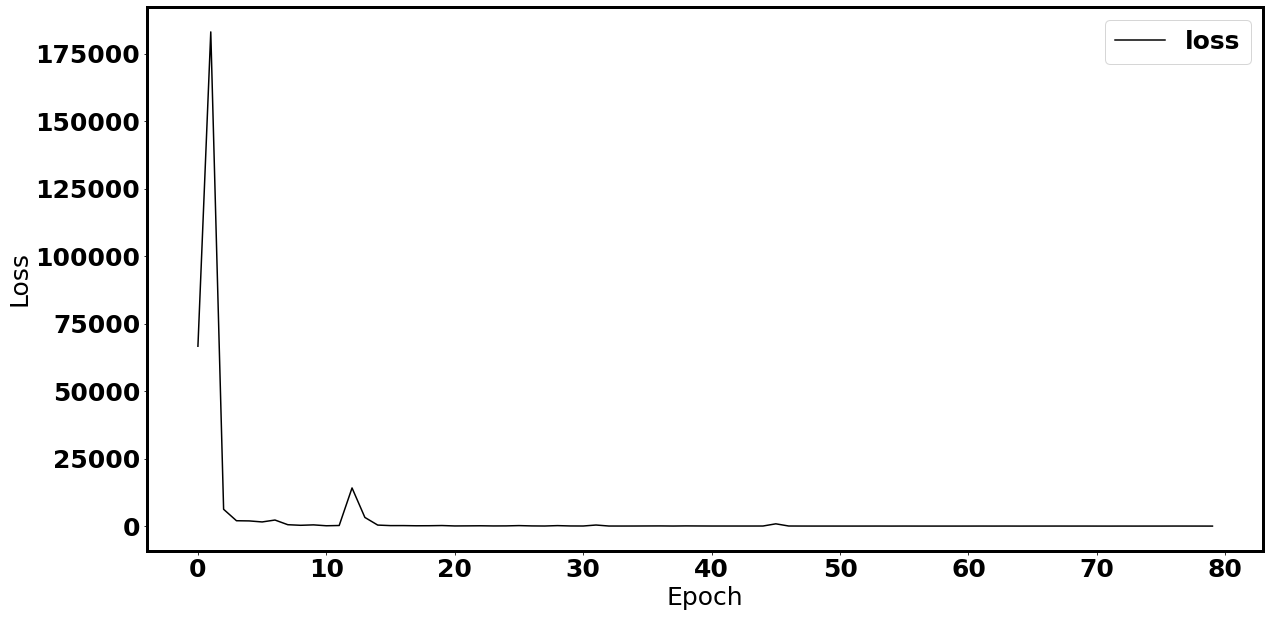

In [16]:
plt.plot(total_losses,"k",label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

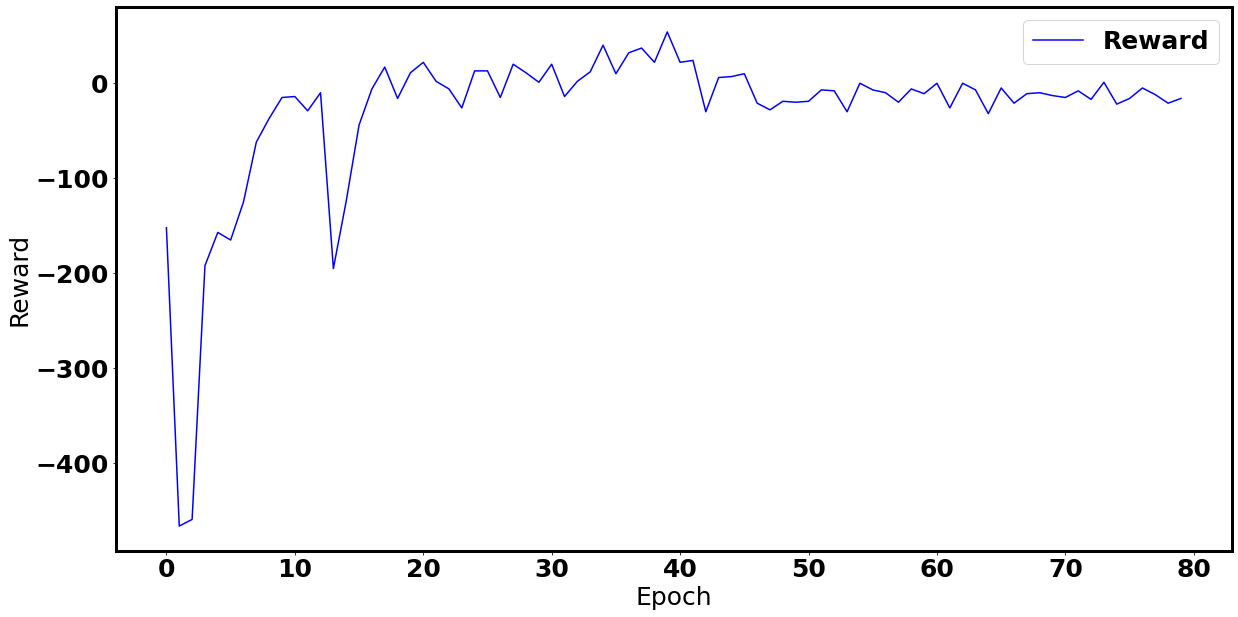

In [18]:
plt.plot(total_rewards,"b",label="Reward")
plt.xlabel("Epoch")
plt.ylabel("Reward")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

In [30]:
train_env,test_env = Environment1(train), Environment1(test)

# train
pobs = train_env.reset()
train_acts = []
train_rewards = []

for _ in range(len(train_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    train_acts.append(pact)

    obs, reward, done = train_env.step(pact)
    train_rewards.append(reward)

    pobs = obs

train_profits = train_env.profits

# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    test_acts.append(pact)

    obs, reward, done = test_env.step(pact)
    test_rewards.append(reward)

    pobs = obs

test_profits = test_env.profits
pobs = train_env.reset()
train_acts = []
train_rewards = []

for _ in range(len(train_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    train_acts.append(pact)

    obs, reward, done = train_env.step(pact)
    train_rewards.append(reward)

    pobs = obs

train_profits = train_env.profits

# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    test_acts.append(pact)

    obs, reward, done = test_env.step(pact)
    test_rewards.append(reward)

    pobs = obs

test_profits = test_env.profits

In [43]:
train_copy = train_env.data.copy()
test_copy = test_env.data.copy()
train_copy['act'] = train_acts + [np.nan]
train_copy['reward'] = train_rewards + [np.nan]
test_copy['act'] = test_acts + [np.nan]
test_copy['reward'] = test_rewards + [np.nan]
train0 = train_copy[train_copy['act'] == 0]
train1 = train_copy[train_copy['act'] == 1]
train2 = train_copy[train_copy['act'] == 2]
test0 = test_copy[test_copy['act'] == 0]
test1 = test_copy[test_copy['act'] == 1]
test2 = test_copy[test_copy['act'] == 2]

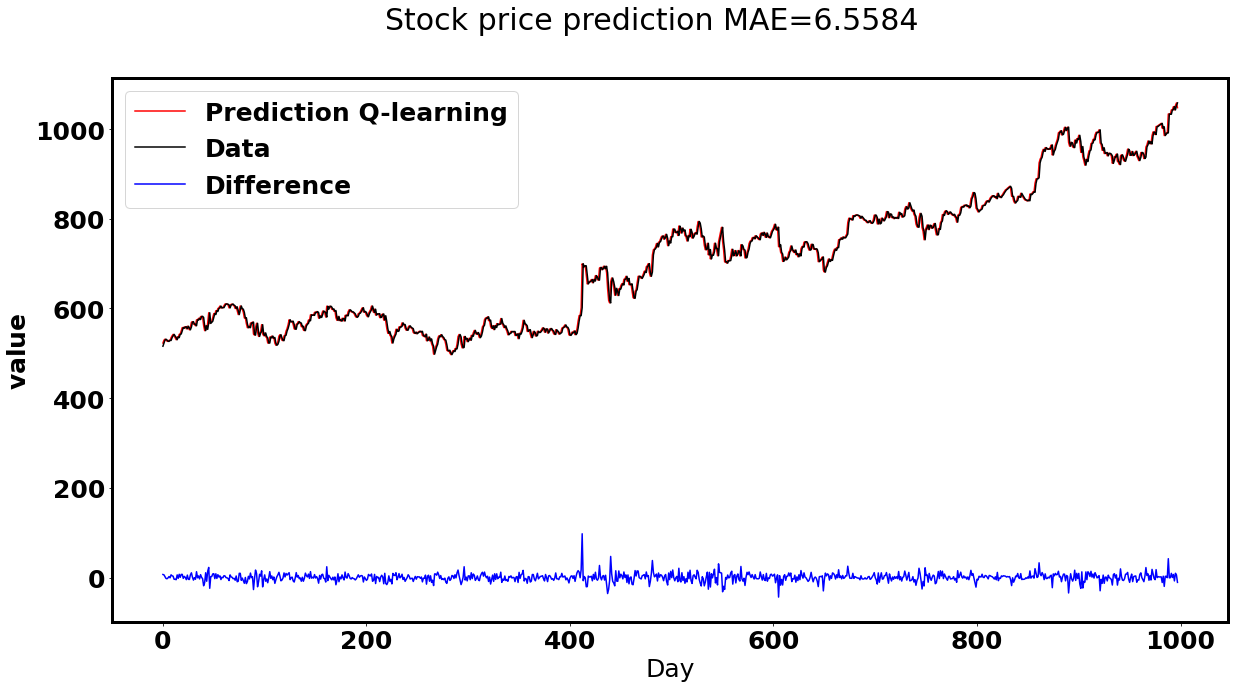

In [82]:
y1 = test0['Close']
y2 = test["Close"]
y2 = y2[:len(y1)].values

plt.plot(np.arange(0,len(y1),1),y1,"r",label="Prediction Q-learning")
plt.plot(np.arange(0,len(y1),1),y2,"k",label="Data")
plt.plot(np.arange(0,len(y1),1),y1-y2,"b",label="Difference")
plt.xlabel("Day")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price prediction MAE=%.4f"%np.nanmean(abs(y1-y2[:len(y1)])))

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()